In [73]:
import os
import sys
sys.path.append('./')
sys.path.append('../')

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import DecisionTreeAttack
from art.estimators.classification import SklearnClassifier
from sklearn.datasets import load_wine

from Core.dataset import CDataset
from Core.tSNE import tSNEPlots

# Step 1: Load dataset

## Wine Dataset (for demo)

In [ ]:
data = load_wine()
X, y = data.data, data.target

# Standardize features for stability
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(np.unique(y, return_counts=True))


## <font color=blue>Kyoto</font>

In [74]:
cDATA = 'Kyoto'

objDS = CDataset()

strFileName =  r'../../DATA/Kyoto2015DS.csv'
#strPath = os.path.join(strRoot, strFileName)
X, y = objDS.GetKyotoDataset(strFileName)
print('Kyoto:', X.shape, y.shape)

fTestSize = 0.9

CDataset Object Created
label
0    30000
1    30000
dtype: int64
Kyoto: (60000, 13) (60000, 1)


## Spilt Data

In [84]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=fTestSize, 
                                                    random_state=42
                                                    )

In [85]:
print('Training Data:', X_train.shape, y_train.shape)
print('Testing Data:', X_test.shape, y_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

Training Data: (6000, 13) (6000, 1)
Testing Data: (54000, 13) (54000, 1)
(array([0, 1], dtype=int64), array([3082, 2918], dtype=int64))
(array([0, 1], dtype=int64), array([26918, 27082], dtype=int64))


## One Hot encoding

In [86]:
enc = OneHotEncoder()
# Training
enc.fit(y_train)  
y_train_cat = enc.transform(y_train).toarray()

# Training
enc.fit(y_test)  
y_test_cat = enc.transform(y_test).toarray()

#print(y_train[0:5])
#print(y_test_cat[0:5])

# Step 2: Train a simple classifier

## SVC

In [ ]:
model = SVC(C=1.0, kernel="rbf") # Working

## <font color=blue>DecisionTreeClassifier</font>

In [87]:
model = DecisionTreeClassifier()
# model = RandomForestClassifier()
# model = MLPClassifier(alpha=1, max_iter=100)

## Fit
    Models are trained on benign and malicious data

In [96]:
model.fit(X_train, y_train)

# Evaluate on clean test set
acc_clean = model.score(X_test, y_test)
print(f"Accuracy on clean test set: {acc_clean:.4f}")

Accuracy on clean test set: 0.9568


# Step 3: Wrap model for ART

In [89]:
classifier = SklearnClassifier(model=model)

classifier.fit(X_train, y_train_cat)

predictions = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_cat, axis=1)) / len(y_test_cat)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 95.71296296296296%


# Step 4: Create adversarial attack

## FGSM

In [ ]:
attack = FastGradientMethod(estimator=classifier, eps=0.1)

## <font color=blue>ART decision tree classifier attack</font>
    Compute adversarial examples on decision trees (as described in by Papernot et al. in https://arxiv.org/abs/1605.07277). Due to the structure of the decision tree, an adversarial example can be computed without any explicit gradients, only by traversing the learned tree structure.

    Consider the following simple decision tree for four dimensional data, where we go to the left if a condition is true:

                        F1<3
            
                F2<5        F2>2
                    
            F4>3     C1    F3<1     C3* 
                
        C1     C2       C3    C1  
        
    Given sample [4,4,1,1], the tree outputs C3 (as indicated by the star). To misclassify the sample, we walk one node up and explore the subtree on the left. We find the leaf outputting C1 and change the two features, obtaining [4,1.9,0.9,1]. In this implementation, we change only the features with wrong values, and specify the offset in advance.

In [94]:
attack = DecisionTreeAttack(classifier)
nSamples = 3000

# Step 5: Generate adversarial examples

In [100]:
X_test_label = np.hstack((X_test, y_test))
print(X_test_label.shape)

value = 0
column_idx = 13
mask = X_test_label[:, column_idx] == value
X_test_label_0 = X_test_label[mask]
print(X_test_label_0.shape)

X_test_selected_sample_0 = X_test_label_0[0:nSamples,0:13]
X_test_selected_label_0 = X_test_label_0[0:nSamples,13]

print(X_test_selected_sample_0.shape,
      X_test_selected_label_0.shape)

(54000, 14)
(26918, 14)
(3000, 13) (3000,)


In [101]:
X_test_adv = attack.generate(x=X_test_selected_sample_0)
print(X_test_adv.shape)

Decision tree attack:   0%|          | 0/3000 [00:00<?, ?it/s]

(3000, 13)


In [ ]:
X_test_adv_label = np.hstack((X_test_adv, 
                              X_test_selected_label_0.reshape(-1,1)))
print(X_test_adv_label.shape)

strOutFileName = '../Data/Kyoto_Adv_3000.csv'
np.savetxt(strOutFileName, X_test_adv_label, 
           delimiter=',',  fmt='%s')

(3000, 14)


# Step 6: Evaluate on adversarial set

In [ ]:
norm_adv = model.score(X_test_selected_sample_0, 
                       X_test_selected_label_0)
print(f"Accuracy on normal test set: {norm_adv:.4f}")

acc_adv = model.score(X_test_adv, X_test_selected_label_0)
print(f"Accuracy on adversarial test set: {acc_adv:.4f}")

Accuracy on normal test set: 0.9583
Accuracy on adversarial test set: 0.0433


In [ ]:
# Optional: Compare a few original vs adversarial samples
print("\nOriginal sample (first row):", X_test[0])
print("Adversarial sample (first row):", X_test_adv[0])

In [110]:
arr_zeros = np.zeros(nSamples).reshape(-1,1)
listOrig = np.hstack((X_test[0:nSamples,], arr_zeros))
print(listOrig.shape)

arr_ones = np.ones(nSamples).reshape(-1,1)
listAdv = np.hstack((X_test_adv, arr_ones))
print(listAdv.shape)

listData = np.vstack((listOrig, listAdv))
dfCols = ['Bin_'+str(i) for i in range(X_test.shape[1])]
dfCols.append('Labels')
#print(dfCols)
df = pd.DataFrame(listData, columns=dfCols)

(3000, 14)
(3000, 14)


Data for tSNE (6000, 13)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.011s...
[t-SNE] Computed neighbors for 6000 samples in 0.129s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 1.839161
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.933495
[t-SNE] KL divergence after 300 iterations: 1.510659


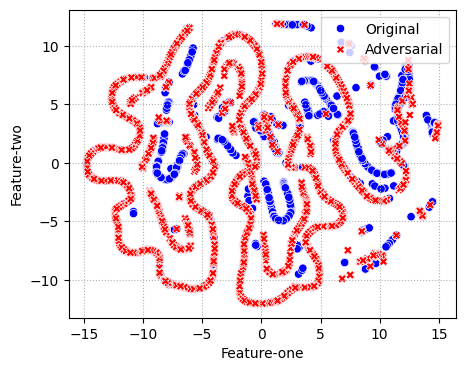

In [111]:
strOutputFile = '../local-data/tsneKyoto_AT.pdf'

tSNEPlots(df, listLabels=['Original', 'Adversarial'], 
              strOutputFile=strOutputFile)